### Imports

In [1]:
from visualization import get_grid_fakes, get_grid_samples
from torch.optim import Adam, RMSprop, AdamW
from samplers import InfSampler
from torch.utils import data
from IPython import display
from stats import GANStats
from training import train
from torch import optim
import torch

### Setup

In [2]:
# Always reload .py files
%load_ext autoreload
%autoreload 2

# Configuration
environment = 'local'


In [3]:
%% capture

# Install dependencies
if environment == 'local':
    %pip install -r ../requirements.txt
else:
    %pip install ipykernel kaggle matplotlib autopep8 pillow pandas numpy scipy urllib3 scikit-image --find-links https: // download.pytorch.org/whl/cu113/torch_stable.html torch == 1.11.0+cu113 torchaudio == 0.11.0+cu113 torchvision == 0.12.0+cu113 torch_tb_profiler tensorboard


UsageError: Cell magic `%%` not found.


In [4]:
if environment == 'colab':
    from google.colab import files
    import pathlib
    import os

    kaggle_path = '/root/.kaggle/kaggle.json'

    if not os.path.exists(kaggle_path):
        uploaded = files.upload()

        if not 'kaggle.json' in uploaded:
            raise Exception('Kaggle.json not found')

        pathlib.Path('/root/.kaggle').mkdir(exist_ok=True)
        os.rename('./kaggle.json', kaggle_path)

        !chmod 600 / root/.kaggle/kaggle.json

In [5]:
from dataset import MonetDataset, download_dataset
import torchvision
import torch


# Define custom paths
data_dir = os.path.join('..', 'data')

# Download the dataset
download_dataset(data_dir)

# Define preprocessing step
process = torchvision.transforms.ConvertImageDtype(torch.float)

# Load datasets
monet_dataset = MonetDataset(monet=True, data_dir=data_dir, transforms=process)
photo_dataset = MonetDataset(monet=False, data_dir=data_dir, transforms=process)

Dataset already exists at ../data


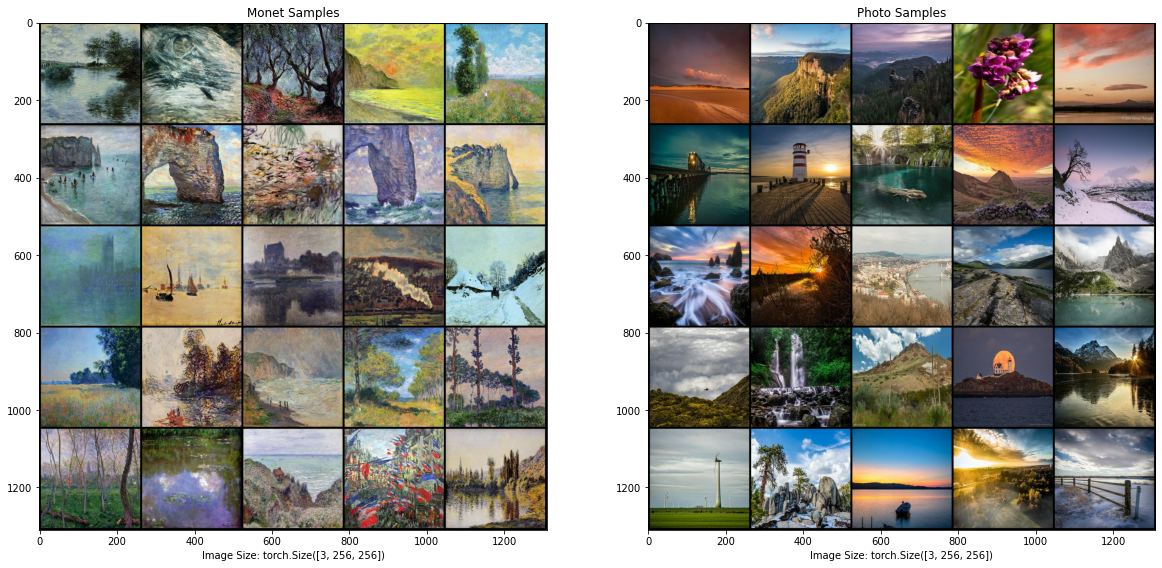

In [6]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Create a dataloader for previewing samples
batch_size = 25
row_count = int(np.sqrt(batch_size))
monet_preview_loader = DataLoader(monet_dataset, batch_size, shuffle=True)
photo_preview_loader = DataLoader(photo_dataset, batch_size, shuffle=True)

# Get a batch of images
monet_preview_imgs = next(iter(monet_preview_loader))
photo_preview_imgs = next(iter(photo_preview_loader))

# Make a grid (image) from a couple of samples from the training dataset
monet_preview_grid = make_grid(
    monet_preview_imgs, nrow=row_count, padding=5, normalize=True)
photo_preview_grid = make_grid(
    photo_preview_imgs, nrow=row_count, padding=5, normalize=True)

# Preview the samples
fig, (monet_axis, photo_axis) = plt.subplots(1, 2, figsize=(20, 20))
monet_axis.set_title('Monet Samples')
monet_axis.set_xlabel(f'Image Size: {monet_preview_imgs[0].size()}')
monet_axis.imshow(monet_preview_grid.permute(1, 2, 0))
photo_axis.set_title('Photo Samples')
photo_axis.set_xlabel(f'Image Size: {photo_preview_imgs[0].size()}')
photo_axis.imshow(photo_preview_grid.permute(1, 2, 0))
plt.show()


### Training

Preparing the Datasets for Training and Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


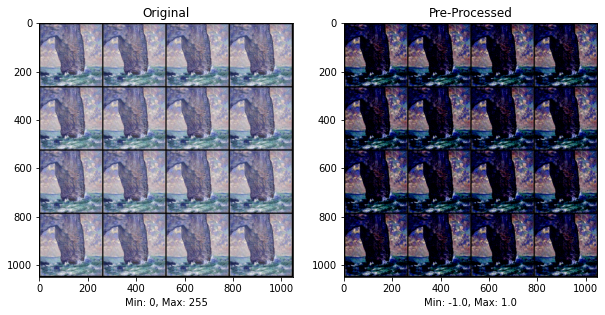

In [7]:
# Custom batch_size
process_workers = 6
batch_size = 16

# Define the pre-processing pipeline
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ConvertImageDtype(dtype=torch.float),
    torchvision.transforms.Normalize(
        [0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5]
    ),
])

# Create the dataset for training
monet_dataset = MonetDataset(
    transforms=preprocess,
    data_dir=data_dir,
    monet=True,
)

# Prepare dataloader - sample random batches without stopping
submonet_dataset = data.Subset(monet_dataset, [0,] * batch_size)
random_sampler = data.RandomSampler(submonet_dataset, replacement=True)
batch_sampler = data.BatchSampler(random_sampler, batch_size=batch_size, drop_last=True)
inf_sampler = InfSampler(batch_sampler)

# Create the dataloader using the batch sampler
data_loader = DataLoader(monet_dataset, batch_sampler=inf_sampler,
                         prefetch_factor=batch_size // 8,
                         num_workers=process_workers)

# Show before and after samples
fig, (orig, proc) = plt.subplots(1, 2, figsize=(10, 5))

# Get samples without preprocessing
monet_dataset.transforms = None
grid_orig = get_grid_samples(submonet_dataset, n_samples=16, normalize=False)

# Get samples with preprocessing
monet_dataset.transforms = preprocess
grid_proc = get_grid_samples(submonet_dataset, n_samples=16, normalize=False)

# Add meta-data
orig.set_xlabel(f'Min: {grid_orig.min()}, Max: {grid_orig.max()}')
proc.set_xlabel(f'Min: {grid_proc.min()}, Max: {grid_proc.max()}')
proc.set_title('Pre-Processed')
orig.set_title('Original')

# Plot the images
orig.imshow(grid_orig)
proc.imshow(grid_proc)
plt.show()

GAN Architecture Initialization

In [8]:
from model import GAN, Discriminator, Generator
from torch import nn

# Use available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Noise tensor dimension
noise_dim = 128

# Define GAN networks
g = Generator(
    in_dim=torch.Size((noise_dim,)),
    hidden_dim=torch.Size((1024, 4, 4)),
    out_dim=torch.Size((3, 256, 256)),
    activ_fun=nn.LeakyReLU(negative_slope=0.2, inplace=True),
    batchnorm=True,
    bias=False,
)

d = Discriminator(
    in_dim=torch.Size((3, 256, 256)),
    hidden_dim=torch.Size((32,)),
    out_dim=torch.Size((1, 1)),
    activ_fun=nn.LeakyReLU(negative_slope=0.2, inplace=True),
    bias=False,
)

# Bundle the networks into a GAN
gan = GAN(g, d).to(device)

Weight Initialization

In [9]:
def init_weights(module: nn.Module):
    if isinstance(module, (nn.Conv2d)):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
    elif isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
        nn.init.normal_(module.weight, mean=1.0, std=0.02)
        nn.init.constant_(module.bias, 0)


# Init the weights and batchnorm params
gan.apply(init_weights)

GAN(
  (G): Generator(
    (activ_fun): LeakyReLU(negative_slope=0.2, inplace=True)
    (out_fun): Tanh()
    (fc1): Linear(in_features=128, out_features=16384, bias=False)
    (gen1): GenerativeBlock(
      (activ_fun): LeakyReLU(negative_slope=0.2, inplace=True)
      (upsample): Upsample(scale_factor=2.0, mode=bilinear)
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (1): Sequential(
          (0): Sequential(
            (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): LeakyReLU(negative_slope=0.2, inplace=True)
          )
          (1): Sequential(
         

Training Parameter Settings

In [10]:
# The total amount of epochs to train for
pretraining = None
num_epochs = 200
epoch_size = 20

# The number of steps the Discriminator trains per-cycle
d_steps = 1

# Create optimizers for each network
optim_D = Adam(gan.D.parameters(), lr=2e-4, betas=(0.5, 0.999))
optim_G = Adam(gan.G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optims = [optim_D, optim_G]

# Clear the gradients of the networks
optim_D.zero_grad()
optim_G.zero_grad()

# Define loss function
loss_fn = torch.nn.BCELoss()

[Epoch      : 30/200]
[Loss      D: 1.3162]
[Loss      G: 1.1189]
[Prob   Real: 0.6468]
[Prob Fake 1: 0.2880]
[Prob Fake 2: 0.2885]


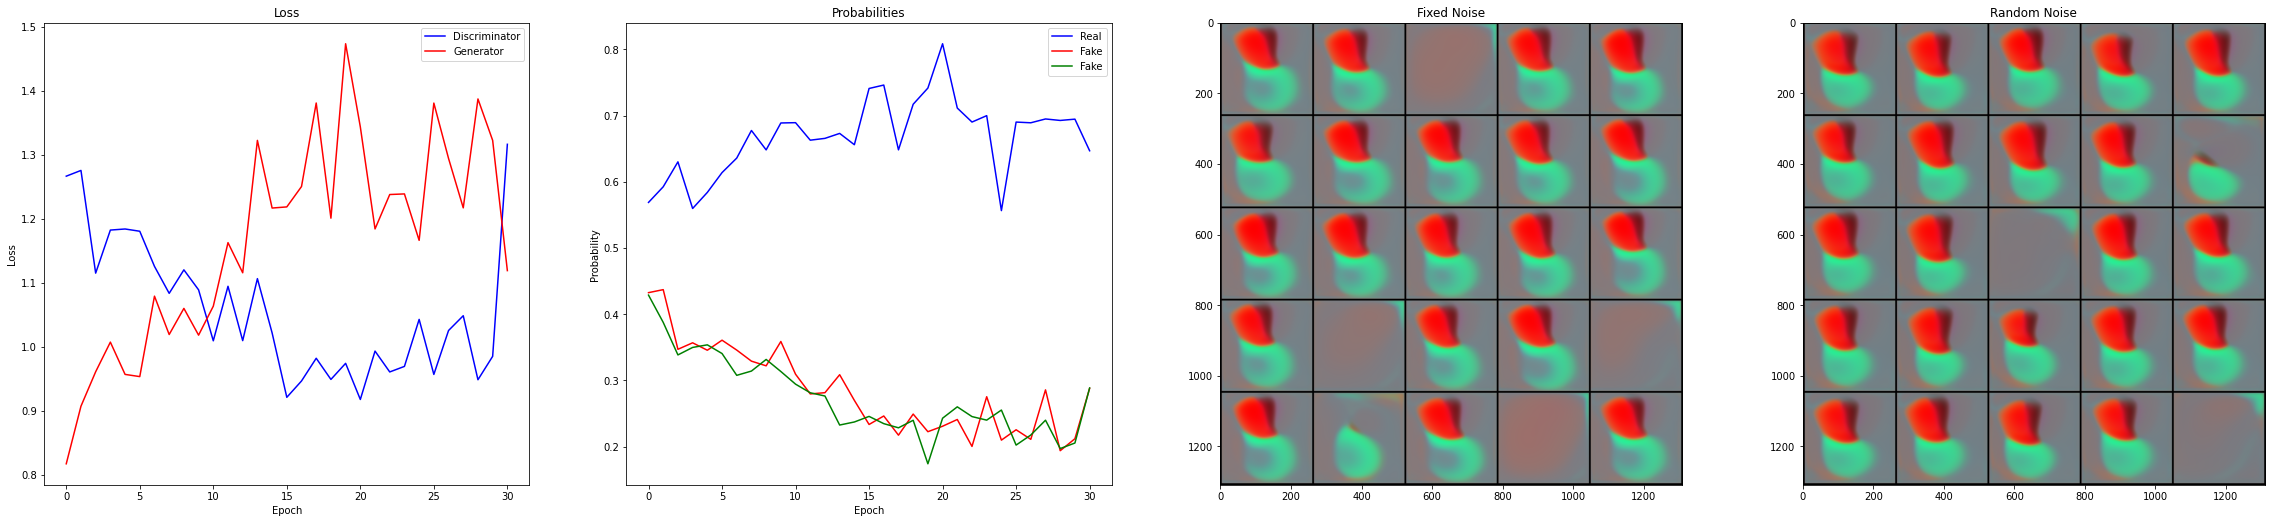

In [11]:
# Training VAR 2
fixed_noise = torch.randn((25, noise_dim), device=device)

# Create iterator and retrive batch_size
it = iter(data_loader)
N, _, _, _ = next(it).size()

# Create fake and true labels with optional noise
real_labels = torch.full((N, ), 0.8, device=device)
fake_labels = torch.full((N, ), 0.1, device=device)

# GAN Statistics
h_prob_real, h_prob_fake, h_fake_prob = [], [], []
h_loss_g, h_loss_d = [], []

# Training loop
for epoch in range(num_epochs):
    for e_step in range(epoch_size):
        # Train the discriminator
        for d_step in range(d_steps):
            # Send real data to the used device
            real_images = next(it).to(device)
            optim_D.zero_grad()

            # Train the discriminator on real images
            prob_real = gan.D(real_images)
            loss_real = loss_fn(prob_real, real_labels)

            # Train the discriminator on fake images
            fake_images = gan.G.generate(torch.Size((N,)))
            prob_fake = gan.D(fake_images.detach())
            loss_fake = loss_fn(prob_fake, fake_labels)

            # Compute the total loss and update
            loss_d = loss_real + loss_fake
            loss_d.backward()
            optim_D.step()

        # Train the generator
        optim_G.zero_grad()
        fake_images = gan.G.generate(torch.Size((N,)))
        fake_prob = gan.D(fake_images)

        # Compute the loss and update
        loss_g = loss_fn(fake_prob, real_labels)
        loss_g.backward()
        optim_G.step()

    # Retain the current stats
    # The losses are averaged over the number of batches
    h_loss_d.append(loss_d.cpu().item())
    h_loss_g.append(loss_g.cpu().item())

    # The probabilities are averaged over the number of batches
    h_prob_real.append(prob_real.cpu().mean().item())
    h_prob_fake.append(prob_fake.cpu().mean().item())
    h_fake_prob.append(fake_prob.cpu().mean().item())

    # Print the losses
    gan.eval()
    with torch.no_grad():
        # Refresh the output
        display.clear_output(wait=True)

        # Print the last stats of the epoch
        print(f'[Epoch      : {epoch}/{num_epochs}]')
        print(f'[Loss      D: {loss_d.item():.4f}]')
        print(f'[Loss      G: {loss_g.item():.4f}]')
        print(f'[Prob   Real: {prob_real.mean().item():.4f}]')
        print(f'[Prob Fake 1: {prob_fake.mean().item():.4f}]')
        print(f'[Prob Fake 2: {fake_prob.mean().item():.4f}]')

        # Display the evolution graphs
        fig, axis = plt.subplots(1, 4, figsize=(40, 8.5))

        # Plot the losses for both the discriminator and the generator
        axis[0].plot(h_loss_d, label='Discriminator', color='blue')
        axis[0].plot(h_loss_g, label='Generator', color='red')
        axis[0].set_title('Loss')
        axis[0].set_ylabel('Loss')
        axis[0].set_xlabel('Epoch')
        axis[0].legend()

        # Plot the probabilities of the discriminator
        axis[1].plot(h_prob_real, label='Real', color='blue')
        axis[1].plot(h_prob_fake, label='Fake', color='red')
        axis[1].plot(h_fake_prob, label='Fake', color='green')
        axis[1].set_title('Probabilities')
        axis[1].set_ylabel('Probability')
        axis[1].set_xlabel('Epoch')
        axis[1].legend()

        # Display the generator output
        axis[2].imshow(get_grid_fakes(gan, fixed_noise, normalize=True).detach().cpu())
        axis[2].set_title('Fixed Noise')
        axis[3].imshow(get_grid_fakes(gan, n_samples=torch.Size((25,)), normalize=True).detach().cpu())
        axis[3].set_title('Random Noise')
        plt.show()
    gan.train()

Training

Epoch 15, D_prob_real=0.51, D_prob_fake1=0.4, D_prob_fake2=0.39, D_loss=1.3, G_loss=0.89


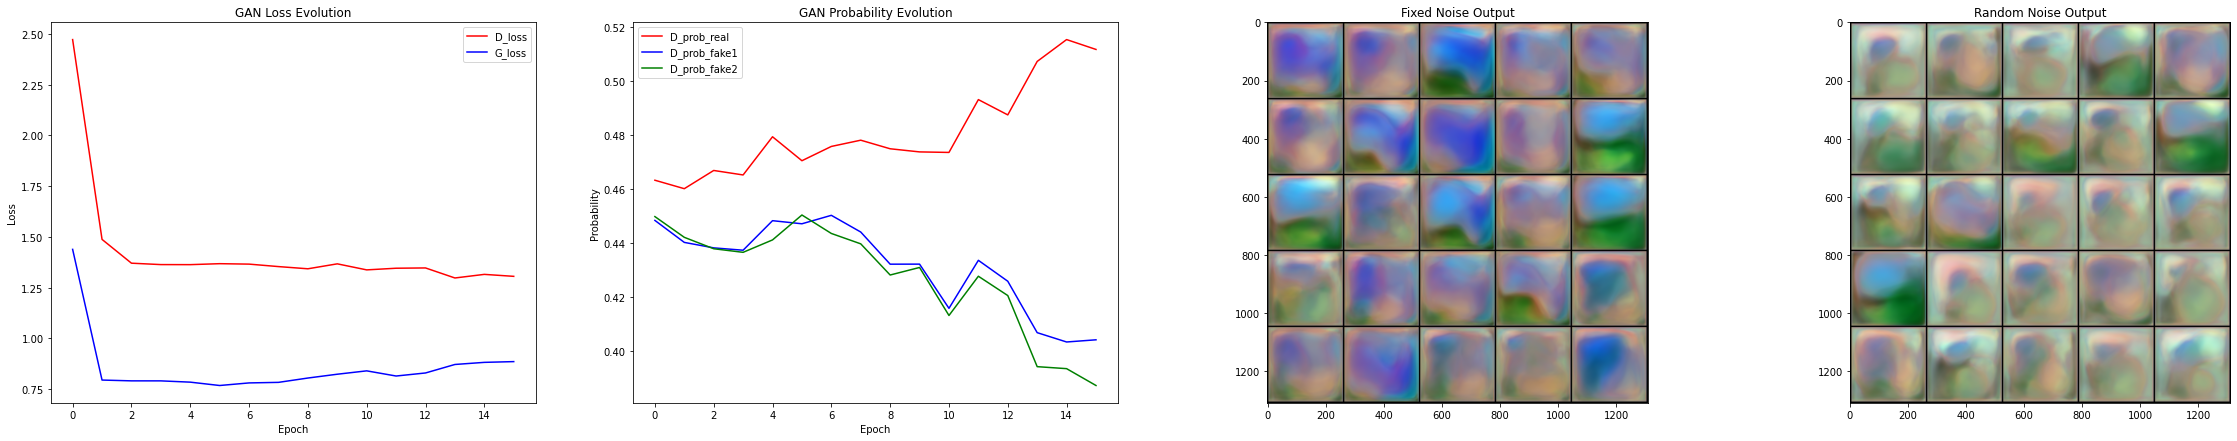

LOSS D:  1.345023512840271
LOSS G:  1.0026899576187134
P Real:  0.45549696683883667
P fake2:  0.33986523747444153


In [11]:
# Evaluate the same noise over time
fixed_noise = torch.randn((25, noise_dim), device=device)

# Train the GAN
# with torch.autograd.detect_anomaly():
train(
    gan=gan,
    device=device,
    optims=optims,
    d_steps=d_steps,
    loss_fn=loss_fn,
    num_epochs=num_epochs,
    epoch_size=epoch_size,
    fixed_noise=fixed_noise,
    fake_label_noise = 0.1,
    real_label_noise = 0.2,
    data_loader=data_loader,
    pretraining=pretraining,
)